**kV Field Size - Otsu Method**

The following script uses a histogram-based binary mask to find the kV Field size. 

I will first input the data from google drive, follow by applying a Gaussian blur to reduce the noise in the image.

(Authors: Alex Grimwood & John Wong)

In [ ]:
###################################
# import all the modules you need #
###################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
from google.colab import drive
drive.mount('/content/drive/')

#####################
# Inputing the data #
#####################
path = '/content/drive/My Drive/kV Field Size/*.bmp'

img = [] # raw image array
name = [] # labels for the image

# find all files and load them into img using a for loop
for fname in glob.glob(path):
    # labeling files
    path,f = os.path.split(fname)
    name.append(f)
    # reading files
    img.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
# convert the list into an array
img = np.array(img, dtype='float32')

#################
# Gaussian blur #
#################
# Applying Gaussian blur to all image
blur_img = [] # create an empty list
for i in range(img.shape[0]): # lopo through images
    blur_img.append(cv2.GaussianBlur(img[i,:,:],(21,21),0)) # blur with a 21x21 pixel kernel
# convert the list into an array
blur_img = np.array(blur_img)

This method will attempt to find the kV Field size by applying Otsu binarisation. 

The thresholding method divides the image's histogram into two classes, so that both classes have the same variance.

The function below will apply the mask and find all four edges of the kV field. 

In [ ]:
def find_v_edge(image):
    """ 
    This function will take an an 8 bit grayscale image and output a 
    threshold image. It will also find two pairs of arrays that define the front
    and rear vertical edge of the kV field.

    input:
        image:         input image, where image must be 2D numpy array

    output: 
        thresh_img:   2D array of the threshold image

        l_cont:       nx2 array containing the left hand field edge coordinates

        r_cont:       nx2 array containing the right hand field edge coordinates

        t_cont:       nx2 array containing the upper field edge coordinates

        b_cont:       nx2 array containing the lower field edge coordinates                     
    """

    # Normalise image
    image = image / image.max()
    image = image * 255
    image = np.round(image)

    # Create binary mask using Otsu's method
    ret, thresh_img = cv2.threshold(image.astype('uint8'),0,255,
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Detect mask contours
    contours, hierarchy = cv2.findContours(thresh_img.astype('uint8'),
                                           cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Detect horizontal and vertical mask edges
    x_edges = thresh_img.max(axis=0).astype(float)
    y_edges = thresh_img.max(axis=1).astype(float)
    x_edges = x_edges[1:]-x_edges[:-1]
    y_edges = y_edges[1:]-y_edges[:-1]

    # Define field edge limits within 100 pixels of mask edges to ignore corners
    x_left = x_edges.argmax()+100
    x_right = x_edges.argmin()-100
    y_top = y_edges.argmax()+100
    y_bottom = y_edges.argmin()-100

    # Classify left and right edge contours whilst ignoring corners
    edge_contour = contours[0].squeeze()
    lr_cont = edge_contour[
        (edge_contour[:,1]>y_top) & (edge_contour[:,1]<y_bottom),:]
    l_cont = lr_cont[lr_cont[:,0]<np.mean(lr_cont[:,0]), :]
    r_cont = lr_cont[lr_cont[:,0]>np.mean(lr_cont[:,0]), :]

    # Classify left and right edge contours whilst ignoring corners
    tb_cont = edge_contour[
        (edge_contour[:,0]>x_left) & (edge_contour[:,0]<x_right),:]
    t_cont = tb_cont[tb_cont[:,1]<np.mean(tb_cont[:,1]), :]
    b_cont = tb_cont[tb_cont[:,1]>np.mean(tb_cont[:,1]), :]    

    return thresh_img, l_cont, r_cont, t_cont, b_cont

The code below was finds the isocentre of the kV field from 4 BBs placed 10 cm from the laser isocentre 

In [ ]:
# average all images together and then extract profiles across small BBs 
avg_img = np.mean(img,0)
h_profile = np.mean(avg_img[603-4:603+4,:],0)
v_profile = np.mean(avg_img[:,799-4:799+4],1)

# find minima indices
a_idx = np.argmin(h_profile[400:500])+400
b_idx = np.argmin(h_profile[1100:1200])+1100
g_idx = np.argmin(v_profile[220:300])+220
t_idx = np.argmin(v_profile[900:995])+900

# calculate pixel size in mm
px_x = 200/(b_idx-a_idx)
px_y = 200/(t_idx-g_idx)
p2mm = (px_x+px_y)/2

# calculate laser centre
laser_isopx = np.array((a_idx + ((b_idx-a_idx)/2), g_idx + ((t_idx-g_idx)/2)))
laser_x, laser_y = laser_isopx

Loop through all images. Identify isocentre from BBs, convert pixels to mm and calculate field dimensions.

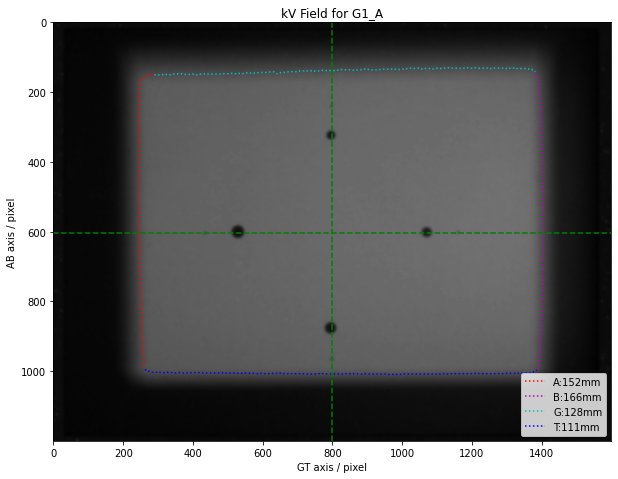

In [ ]:
for img_no in np.arange(len(blur_img)):

  # Otsu function
  result, x_left, x_right, y_top, y_bottom = find_v_edge(blur_img[img_no])

  # Calculating edge to isocentre size
  A = (laser_x - np.average(x_left[:,0])) * p2mm
  B = (np.average(x_right[:,0]) - laser_x) * p2mm
  G = (laser_y - np.average(y_bottom[:,1])) * p2mm
  T = (np.average(y_top[:,1]) - laser_y) * p2mm
  ##############################################################################
  # plotting the binary image with the edge line   
  plt.figure(figsize=(10, 10))   

  # Display image with the gaussian blur
  plt.imshow(blur_img[img_no,:,:], cmap='gray', vmin=0, vmax=75)
  # vertical edge
  plt.plot(x_left[:,0], x_left[:,1], color='r', linestyle='dotted',label='A:{:.0f}mm'.format(A))
  plt.plot(x_right[:,0], x_right[:,1], color='m', linestyle='dotted',label='B:{:.0f}mm'.format(B))
  # horizontal edge
  plt.plot(y_bottom[:,0], y_bottom[:,1], color='c', linestyle='dotted',label='G:{:.0f}mm'.format(G))
  plt.plot(y_top[:,0], y_top[:,1], color='b', linestyle='dotted',label='T:{:.0f}mm'.format(T))
  # isocentre
  plt.axvline(x = laser_x, color='g', linestyle='--')
  plt.axhline(y = laser_y, color='g', linestyle='--')
  # graph setting
  plt.title("kV Field for {}".format(name[img_no]))
  plt.xlabel("GT axis / pixel")
  plt.ylabel("AB axis / pixel")
  plt.legend(loc='lower right')
  #plt.savefig('result_{}.png'.format(name[img_no]))

  plt.show()

The script serve their purupose and find clearly defined edges. However, we can make a few improvements:

1) We can try to develop a bit of code to find a different binary threshold for each image

2) There are too many for loops in the scripts, so the code take some time to run